In [2]:
import numpy as np 
import pandas as pd 
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("/Users/jerrysong/Desktop/fraud-detection/input"))

['test_transaction.csv', '.DS_Store', 'train_transaction_1.csv', 'train_identity.csv', 'merge.csv', 'train_transaction_del.csv', 'test_identity.csv', 'merge_1.csv', 'merge_2.csv', 'sample_submission.csv', 'train_transaction.csv', 'merge_3.csv']


In [12]:
df_id = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/train_identity.csv")
df_trans = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/train_transaction_1.csv")

In [13]:
df_id.head(5)

,TransactionID,id_12,id_15,id_23,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,NotFound,New,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,NotFound,New,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,NotFound,Found,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,NotFound,New,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,NotFound,Found,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
df_trans.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,315.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_id_rnn = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/train_identity.csv")
df_trans_rnn = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/train_transaction_del.csv")

In [20]:
result_rnn = pd.merge(df_trans_rnn, df_id_rnn, on='TransactionID',how = 'inner')

In [21]:
result_rnn.to_csv('/Users/jerrysong/Desktop/fraud-detection/input/merge_1.csv', header=True, index=False)

In [22]:
result_rnn.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3491946,0,13216057,100.000,R,11066,555.0,150.0,visa,226.0,...,mobile safari generic,32.0,2208x1242,match_status:1,T,F,F,F,mobile,iOS Device
1,3491955,0,13216264,100.000,R,3621,277.0,144.0,visa,147.0,...,chrome generic,24.0,1440x900,match_status:2,T,F,T,F,desktop,MacOS
2,3491957,0,13216266,46.233,C,2884,490.0,150.0,visa,226.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
3,3491963,0,13216399,46.233,C,8117,490.0,150.0,visa,226.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
4,3491968,0,13216499,7.808,C,9300,103.0,185.0,visa,138.0,...,chrome 64.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto C Plus Build/NRD90M.05.034
5,3491977,0,13216631,20.000,S,13780,298.0,150.0,visa,226.0,...,chrome generic,24.0,2220x1081,match_status:2,T,F,T,T,desktop,NaN
6,3491996,0,13216909,100.000,R,3682,264.0,150.0,visa,162.0,...,mobile safari generic,32.0,2048x1536,match_status:2,T,F,T,F,mobile,iOS Device
7,3492013,0,13217138,14.940,C,5595,545.0,185.0,visa,138.0,...,chrome 61.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-J500M Build/MMB29M
8,3492020,0,13217332,30.000,S,14349,170.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3492024,0,13217429,56.316,C,13888,224.0,106.0,mastercard,137.0,...,mobile safari generic,NaN,NaN,NaN,F,F,F,F,mobile,NaN


In [49]:
df_merge = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/merge_2.csv")
#df_merge=df_merge['card5'].fillna(df_merge['card5'].mean())
#df_merge=df_merge['addr2'].fillna(df_merge['addr2'].mean(),inplace=True)
for column in list(df_merge.columns[df_merge.isnull().sum() > 0]):
    mean_val = df_merge[column].mean()
    df_merge[column].fillna(mean_val, inplace=True)

merge_3=df_merge
merge_3.to_csv('/Users/jerrysong/Desktop/fraud-detection/input/merge_3.csv', header=True, index=False)

In [48]:
df_merge.head(100)

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card5,addr1,addr2,...,D15,V13,V14,V17,V23,V26,V27,V29,id_32,Unnamed: 39
0,3491946,0,100.000,R,11066,555.0,150.0,226.0,203.000000,87.000000,...,48.593652,0.0,0.998053,1.049542,1.216953,0.996449,0.004696,0.0,32.000000,visa debit gmail.com yahoo.com NotFound New N...
1,3491955,0,100.000,R,3621,277.0,144.0,147.0,356.000000,96.000000,...,48.593652,0.0,0.998053,1.049542,1.216953,0.996449,0.004696,0.0,24.000000,visa credit anonymous.com anonymous.com NotFo...
2,3491957,0,46.233,C,2884,490.0,150.0,226.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,visa debit gmail.com gmail.com M2 NotFound New...
3,3491963,0,46.233,C,8117,490.0,150.0,226.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,visa debit gmail.com gmail.com M2 NotFound Fou...
4,3491968,0,7.808,C,9300,103.0,185.0,138.0,301.303436,86.300086,...,83.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,visa debit gmail.com gmail.com M2 NotFound Fou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3492665,0,115.152,C,1700,305.0,106.0,224.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,mastercard debit gmail.com gmail.com M2 NotFou...
96,3492670,0,59.759,C,9633,130.0,185.0,138.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,visa debit gmail.com gmail.com M2 NotFound Unk...
97,3492677,0,45.495,C,1700,305.0,106.0,224.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,mastercard debit gmail.com gmail.com M2 NotFou...
98,3492693,0,44.266,C,8755,500.0,185.0,224.0,301.303436,86.300086,...,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,26.463252,mastercard credit hotmail.com hotmail.com M2 N...


In [52]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary


In [53]:
#to reduce the size of DF 
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [54]:
def CalcOutliers(df_num):
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    # setting the cut line
    cut = data_std * 3
    lower, upper = data_mean - cut, data_mean + cut
    #creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) #  lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [14]:
#Reducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [59]:
resumetable(df_trans)[:40]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int64,0,2,0,0,0,0.22
2,TransactionDT,int64,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float64,0,20902,68.5,29,59,8.35
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int64,0,13553,13926,2755,4663,9.97
6,card2,float64,8933,500,NaN,404,490,6.32
7,card3,float64,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float64,4259,119,142,102,166,2.66


In [35]:
resumetable(df_id)[:34]

Dataset Shape: (144233, 41)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,144233,2987004,2987008,2987010,17.14
1,id_01,float64,0,77,0,-5,-5,2.27
2,id_02,float64,3361,115655,70787,98945,191631,16.72
3,id_03,float64,77909,24,NaN,NaN,0,0.32
4,id_04,float64,77909,15,NaN,NaN,0,0.10
5,id_05,float64,7368,93,NaN,0,0,2.40
6,id_06,float64,7368,101,NaN,-5,0,2.63
7,id_07,float64,139078,84,NaN,NaN,NaN,5.39
8,id_08,float64,139078,94,NaN,NaN,NaN,5.72
9,id_09,float64,69307,46,NaN,NaN,0,0.51


## Show the data first

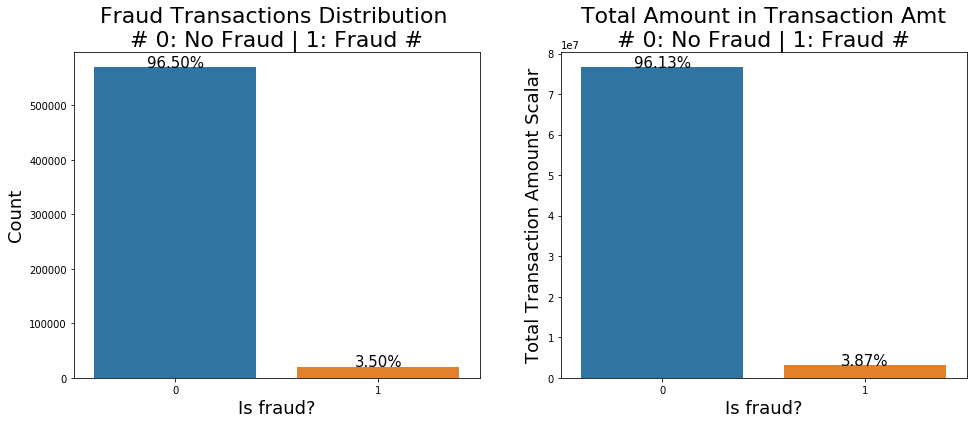

In [36]:
#原本数据集的比列
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title(" Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

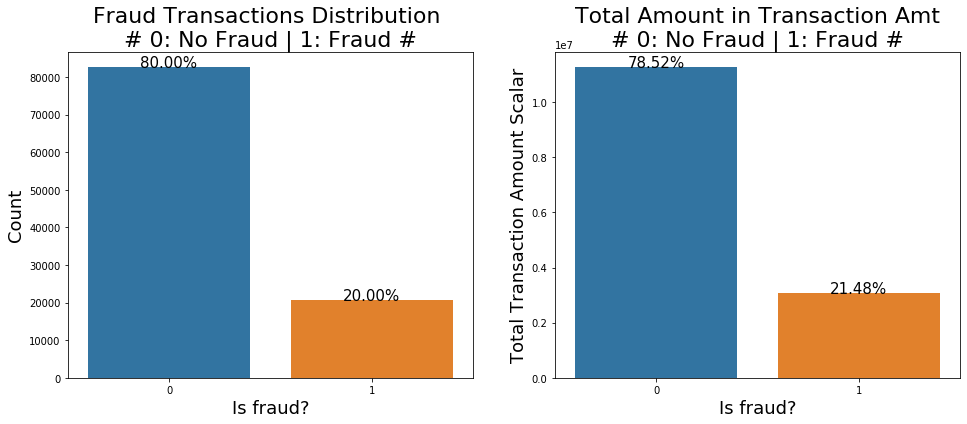

In [24]:
#处理后本数据集的比列
df_trans_rnn['TransactionAmt'] = df_trans_rnn['TransactionAmt'].astype(float)
total = len(df_trans_rnn)
total_amt = df_trans_rnn.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans_rnn, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans_rnn.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title(" Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

## quantiles of Transaction Amount

In [62]:
#quantiles of Transaction Amount
df_trans_rnn['TransactionAmt'] = df_trans_rnn['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans_rnn['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       7.99300
0.025      12.30905
0.100      25.95000
0.250      41.00000
0.500      69.10400
0.750     129.95000
0.900     280.00000
0.975     691.00000
0.990    1141.85190
Name: TransactionAmt, dtype: float64


In [64]:
print(pd.concat([df_trans_rnn[df_trans['isFraud'] == 1]['TransactionAmt'].quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index(), 
                 df_trans_rnn[df_trans_rnn['isFraud'] == 0]['TransactionAmt'].quantile([.01, .1, .25, .5, .75, .9, .99]) .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01        8.11872     0.01          8.361
1  0.10       25.95000     0.10         26.950
2  0.25       40.00000     0.25         44.000
3  0.50       73.28400     0.50         68.500
4  0.75      139.95000     0.75        117.000
5  0.90      300.00000     0.90        261.950
6  0.99     1104.00000     0.99       1232.470


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [39]:
#Transaction Amount Outliers
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10093
Total outlier observations: 10093
Non-outlier observations: 580447
Total percentual of Outliers:  1.7388


## Product (ProductCD)

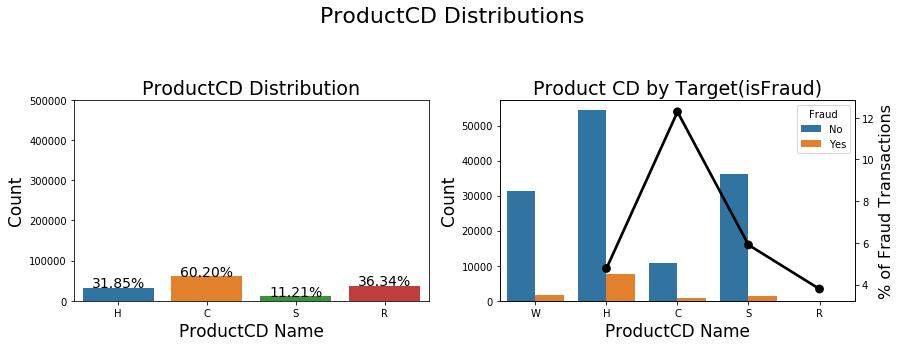

In [73]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)


plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

## Card Features

In [76]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3
0.010   1281.0  103.0  106.0
0.025   1724.0  103.0  119.0
0.100   2884.0  130.0  150.0
0.250   5713.0  264.0  150.0
0.500   9633.0  408.0  150.0
0.750  15063.0  545.0  185.0
0.975  17872.0  583.0  185.0
0.990  18268.0  583.0  190.0


 Card 1 and Card 2 has a large distribution of values

### plot the distribution of card1 and card2

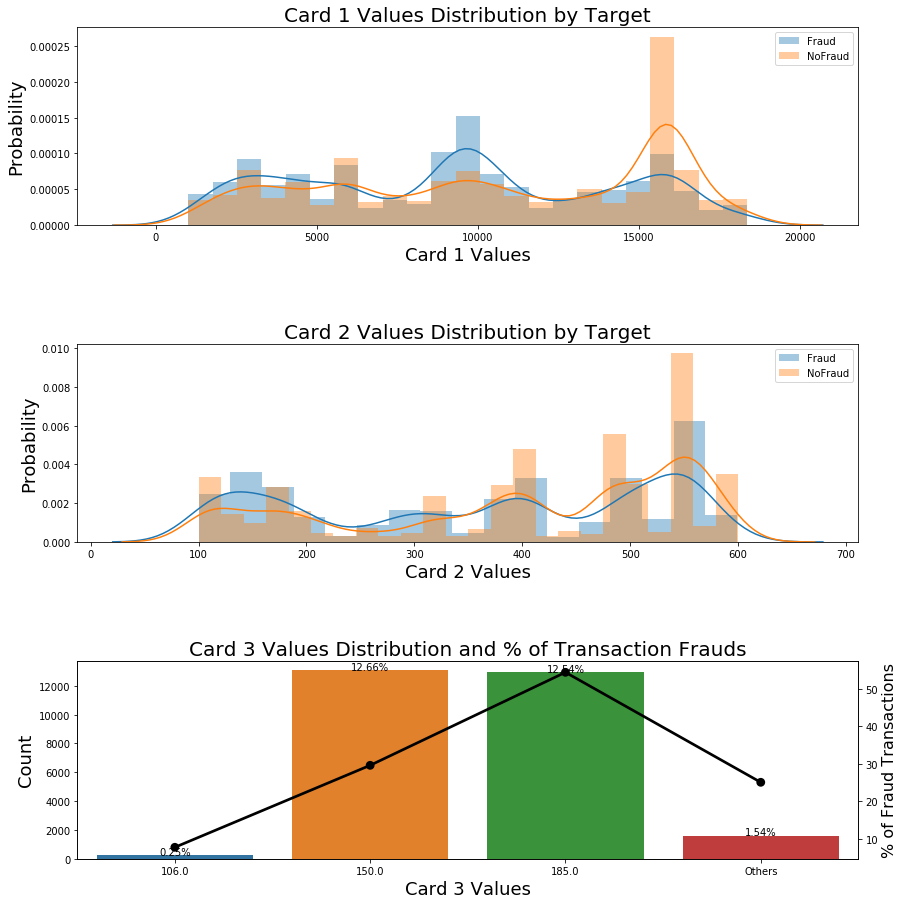

In [82]:
df_trans=pd.read_csv("/Users/jerrysong/Desktop/ieee-fraud-detection/input/merge_3.csv")
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"


tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

In [60]:
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.000000,80044.000000,140985,129340,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,...,140978,77565,140282,77586.000000,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,48.053071,-344.507146,NaN,NaN,189.451377,14.237337,353.128174,403.882666,368.269820,...,NaN,NaN,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,11.774858,93.695502,NaN,NaN,30.375360,1.561302,141.095343,152.160327,198.847038,...,NaN,NaN,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.000000,-660.000000,NaN,NaN,100.000000,10.000000,100.000000,100.000000,100.000000,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.000000,-360.000000,NaN,NaN,166.000000,13.000000,266.000000,256.000000,252.000000,...,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.000000,-300.000000,NaN,NaN,166.000000,15.000000,341.000000,472.000000,252.000000,...,NaN,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.000000,-300.000000,NaN,NaN,225.000000,15.000000,427.000000,533.000000,486.500000,...,NaN,NaN,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df_train_rnn = df_trans_rnn.merge(df_id, how='left', left_index=True, right_index=True)

In [59]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
        
        plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

## Features [id_12 to id_38]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



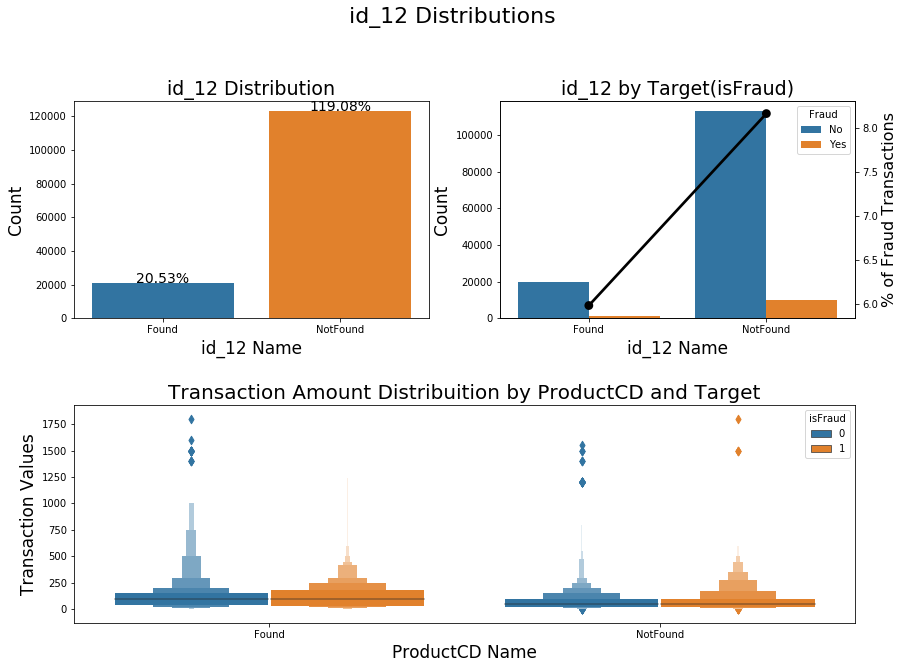

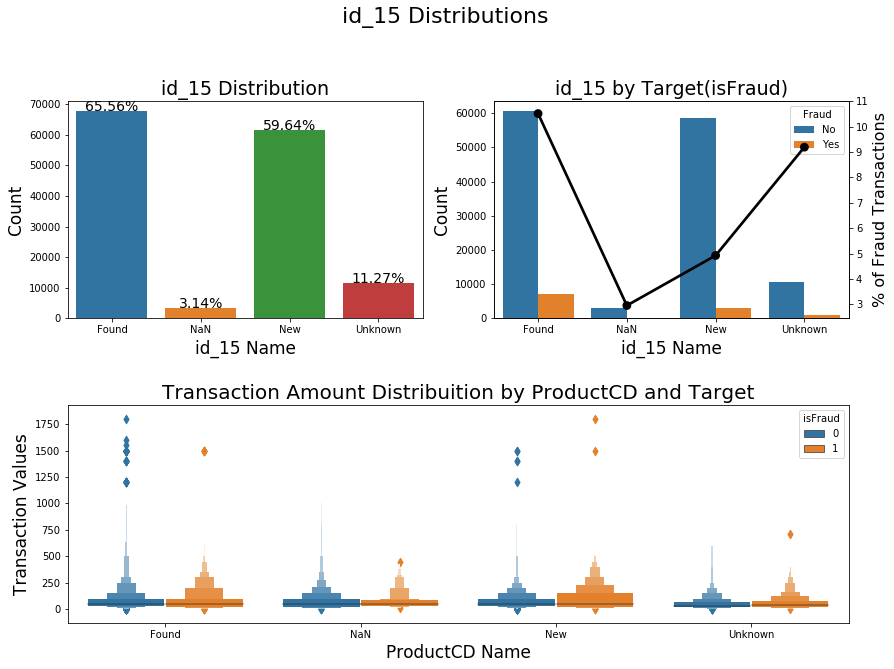

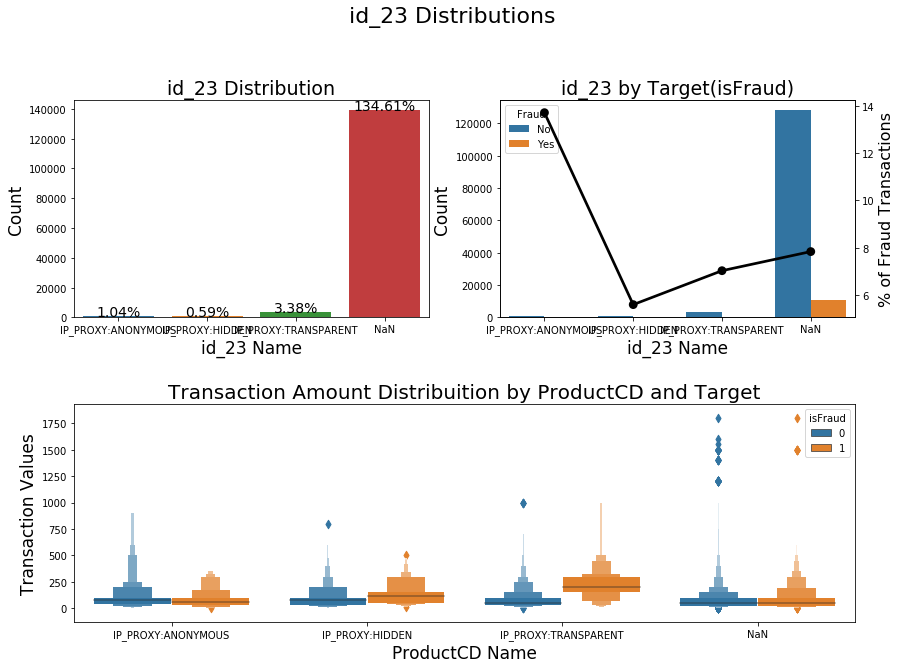

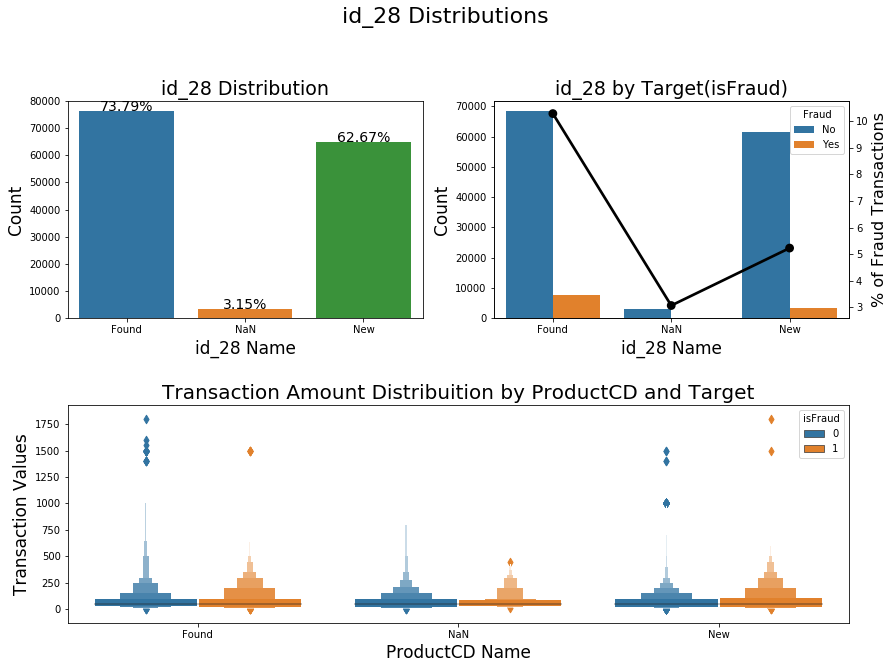

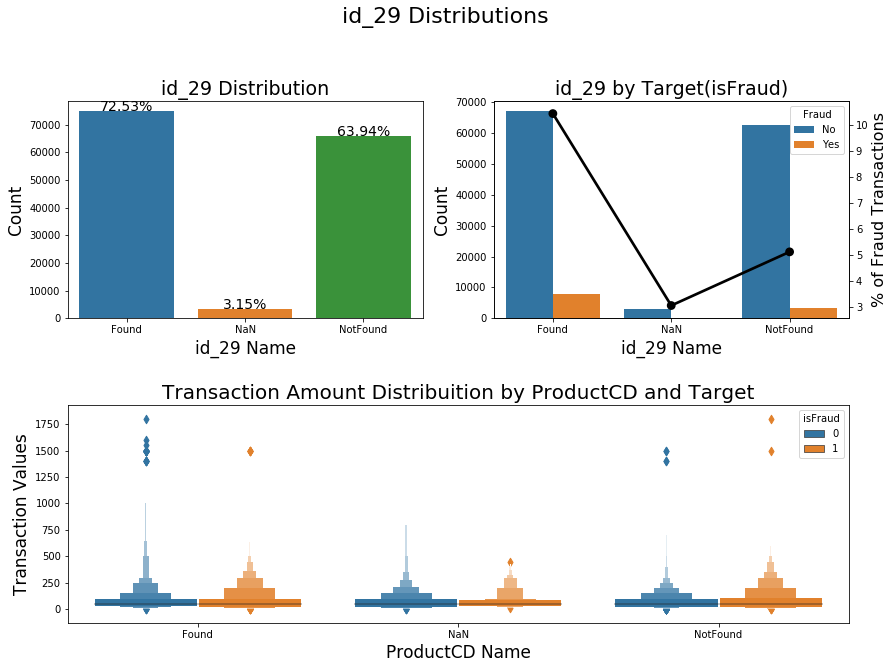

In [61]:
df_trans = pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/merge_1.csv")
for col in ['id_12', 'id_15', 'id_23','id_28', 'id_29']:
    df_trans[col] = df_trans[col].fillna('NaN')
    cat_feat_ploting(df_trans, col)

In [5]:
df_trans=pd.read_csv("/Users/jerrysong/Desktop/fraud-detection/input/merge_1.csv")
df_trans.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3491946,0,13216057,100.000,R,11066,555.0,150.0,visa,226.0,...,mobile safari generic,32.0,2208x1242,match_status:1,T,F,F,F,mobile,iOS Device
1,3491955,0,13216264,100.000,R,3621,277.0,144.0,visa,147.0,...,chrome generic,24.0,1440x900,match_status:2,T,F,T,F,desktop,MacOS
2,3491957,0,13216266,46.233,C,2884,490.0,150.0,visa,226.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
3,3491963,0,13216399,46.233,C,8117,490.0,150.0,visa,226.0,...,chrome 65.0,NaN,NaN,NaN,F,F,T,F,desktop,Windows
4,3491968,0,13216499,7.808,C,9300,103.0,185.0,visa,138.0,...,chrome 64.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto C Plus Build/NRD90M.05.034


NameError: name 'total' is not defined

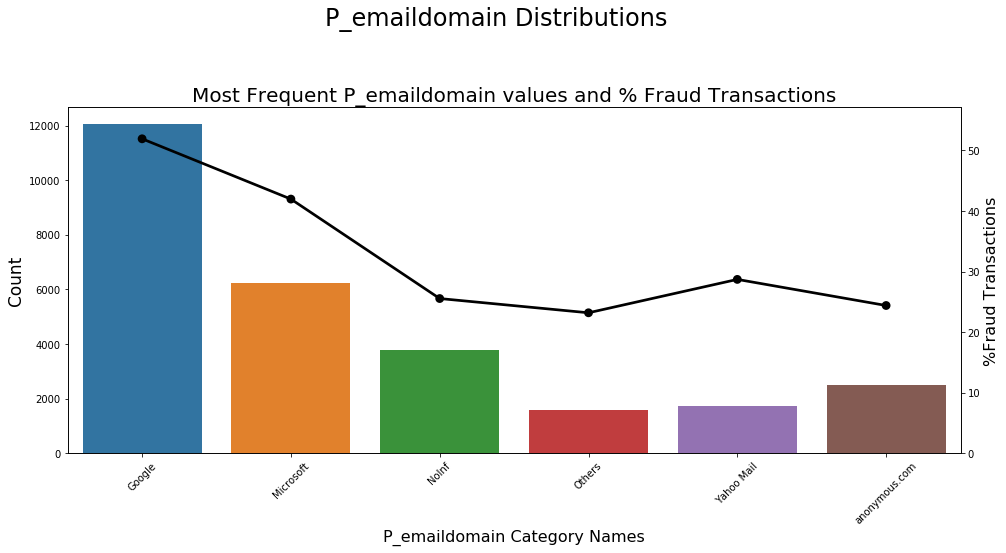

In [8]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)

df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

ploting_cnt_amt(df_trans, 'P_emaildomain')

NameError: name 'total' is not defined

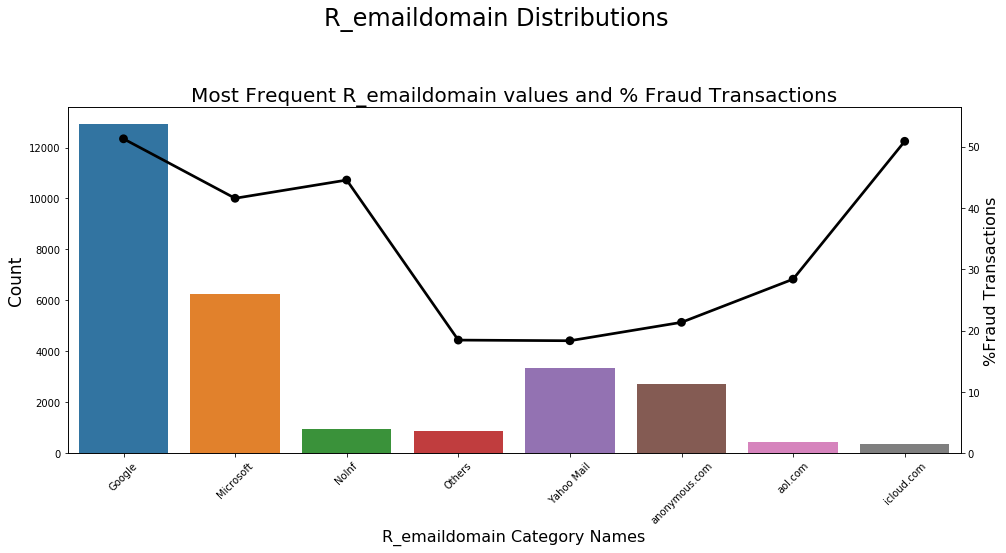

In [9]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)


ploting_cnt_amt(df_trans, 'R_emaildomain')

In [95]:
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,1.611525,1.721392,1.486472,1.522249,outlook,com,None,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.686169,0.606586,0.576638,0.536412,yahoo,com,None,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN


In [96]:
test.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,1.557394,1.760048,1.450810,1.477451,gmail,com,None,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,3.033737,2.728290,2.300422,2.290230,aol,com,None,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,0.457103,0.417420,0.351657,0.350398,hotmail,com,None,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,1.020278,1.041398,0.901970,0.874189,gmail,com,None,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,0.098978,0.094673,0.080181,0.079472,gmail,com,None,NaN,NaN,NaN


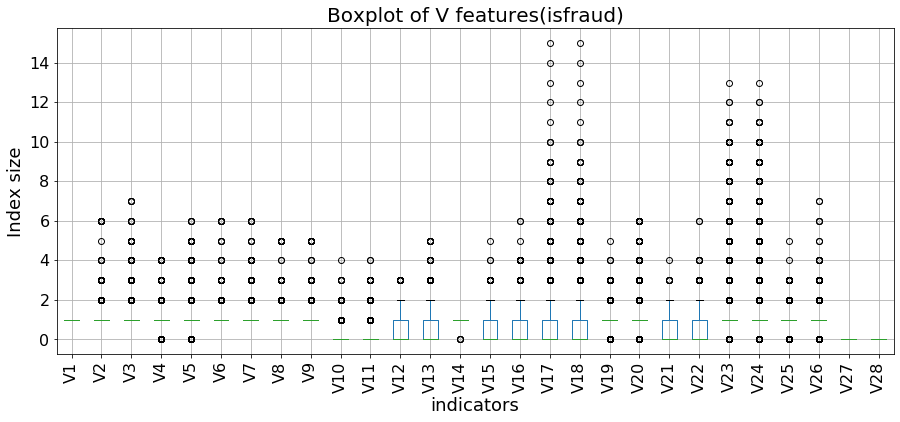

In [11]:
data=pd.read_csv(r'/Users/jerrysong/Desktop/ieee-fraud-detection/input/train_transaction.csv',sep=',')#导入数据
#data['Hour']=data["Time"].apply(lambda x : divmod(x, 3600)[0])#把时间转化为小时为单位
#对Amount和Hour进行标准化
from sklearn.preprocessing import StandardScaler # 导入模块
sc =StandardScaler() # 初始化缩放器
#data[['Amount','Hour']] =sc.fit_transform(data[['Amount','Hour']])#对数据进行标准化

data_fraud=data[data['isFraud']==1]#欺诈数据
data_notfraud=data[data['isFraud']==0]#非欺诈数据

#画出欺诈数据各指标的箱线图
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.figure(figsize=(15,6))
data_fraud[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']].boxplot()
plt.title('Boxplot of V features(isfraud)',fontsize=20)
plt.xlabel('indicators',fontsize=18)
plt.ylabel('Index size',fontsize=18)
plt.xticks(rotation=90)#旋转横坐标
plt.tick_params(labelsize=16)#增大横坐标刻度大小
plt.show()



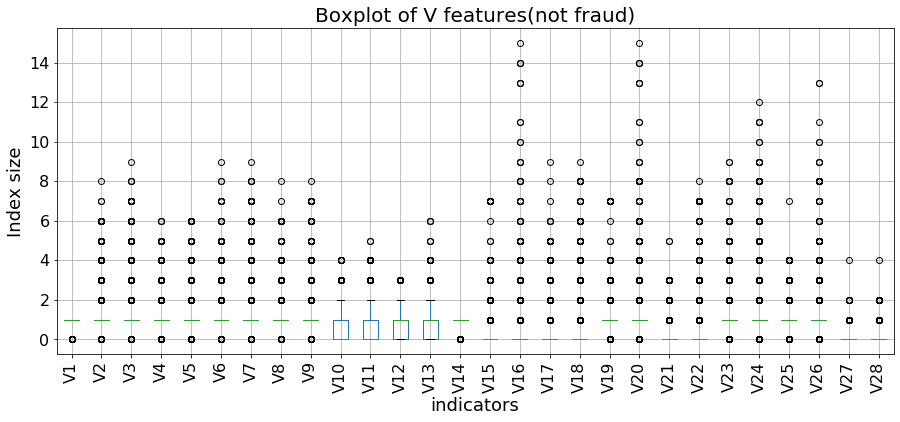

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.figure(figsize=(15,6))
data_notfraud[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']].boxplot()
plt.title('Boxplot of V features(not fraud)',fontsize=20)
plt.xlabel('indicators',fontsize=18)
plt.ylabel('Index size',fontsize=18)
plt.xticks(rotation=90)#旋转横坐标
plt.tick_params(labelsize=16)#增大横坐标刻度大小
plt.show()